## 预先定义参数

logg 生成记录

In [1]:
import logging
import sys
from time import strftime, localtime
import time
from sklearn import metrics
from transformers import BertModel
from transformers import BertTokenizer
import warnings
warnings.filterwarnings("ignore")

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler(sys.stdout))

In [2]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--model_name', default='shap_lstm', type=str)
parser.add_argument('--dataset', default='restaurant', type=str, help='twitter, restaurant, laptop')
parser.add_argument('--optimizer', default='adam', type=str)
parser.add_argument('--dropout', default=0.1, type=float)
parser.add_argument('--initializer', default='xavier_uniform_', type=str)
parser.add_argument('--learning_rate', default=1e-3, type=float)
parser.add_argument('--dropout_rate', default=0.1, type=float)
parser.add_argument('--num_epoch', default=10, type=int)
parser.add_argument('--batch_size', default=16, type=int)
parser.add_argument('--embed_dim', default=300, type=int)
parser.add_argument('--hidden_dim', default=300, type=int)
parser.add_argument('--max_seq_len', default=40, type=int)
parser.add_argument('--device', default=None, type=str, help='e.g. cuda:0')
parser.add_argument('--seed', default=1234, type=int, help='set seed for reproducibility')
parser.add_argument('--l2reg', default=0.001, type=float)
parser.add_argument('--valset_ratio', default=0, type=float)
parser.add_argument('--polarities_dim', default=3, type=int)


parser.add_argument('--bert_dim', default=768, type=int)
parser.add_argument('--pretrained_bert_name', default='bert-base-uncased', type=str)
parser.add_argument('--hops', default=3, type=int)

opt = parser.parse_args([])


In [3]:
import random
import numpy as np
import torch

if opt.seed is not None:
    print('Set seed for whole model.')
    random.seed(opt.seed)
    np.random.seed(opt.seed)
    torch.manual_seed(opt.seed)
    torch.cuda.manual_seed(opt.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    

Set seed for whole model.


Hyper parameters

In [4]:
from models import LSTM, SHAP_LSTM,ATAE_LSTM, AOA, TNet_LF, SHAP_AOA, SHAP_BERT
from models.bert_spc import BERT_SPC

model_classes = {
    'lstm': LSTM,
    'atae_lstm': ATAE_LSTM,
    'shap_lstm': SHAP_LSTM,
    'aoa': AOA,
    'tnet_lf': TNet_LF,
    'shap_aoa': SHAP_AOA,
    'bert_spc': BERT_SPC,
    'shap_bert': SHAP_BERT
}

# datsets files path
dataset_files = {
    'twitter': {
        'train': './datasets/acl-14-short-data/train.raw',
        'test': './datasets/acl-14-short-data/test.raw'
    },
    'restaurant': {
        'train': './datasets/semeval14/Restaurants_Train.xml.seg',
        'test': './datasets/semeval14/Restaurants_Test_Gold.xml.seg'
    },
    'laptop': {
        'train': './datasets/semeval14/Laptops_Train.xml.seg',
        'test': './datasets/semeval14/Laptops_Test_Gold.xml.seg'
    }
}

input_colses = {
    'lstm': ['text_raw_indices', 'aspect_indices'],
    'td_lstm': ['text_left_with_aspect_indices', 'text_right_with_aspect_indices'],
    'tc_lstm': ['text_left_with_aspect_indices', 'text_right_with_aspect_indices', 'aspect_indices'],
    'shap_lstm': ['text_raw_indices', 'aspect_indices'],
    'atae_lstm': ['text_raw_indices', 'aspect_indices'],
    'ian': ['text_raw_indices', 'aspect_indices'],
    'memnet': ['text_raw_without_aspect_indices', 'aspect_indices'],
    'ram': ['text_raw_indices', 'aspect_indices', 'text_left_indices'],
    'cabasc': ['text_raw_indices', 'aspect_indices', 'text_left_with_aspect_indices', 'text_right_with_aspect_indices'],
    'tnet_lf': ['text_raw_indices', 'aspect_indices', 'aspect_in_text'],
    'aoa': ['text_raw_indices', 'aspect_indices'],
    'shap_aoa': ['text_raw_indices', 'aspect_indices'],
    'mgan': ['text_raw_indices', 'aspect_indices', 'text_left_indices'],
    'bert_spc': ['text_bert_indices', 'bert_segments_ids'],
    'aen_bert': ['text_raw_bert_indices', 'aspect_bert_indices'],
    'lcf_bert': ['text_bert_indices', 'bert_segments_ids', 'text_raw_bert_indices', 'aspect_bert_indices'],
    'shap_bert': ['text_bert_indices', 'bert_segments_ids', 'aspect_bert_indices']
}

initializers = {
    'xavier_uniform_': torch.nn.init.xavier_uniform_,
    'xavier_normal_': torch.nn.init.xavier_normal,
    'orthogonal_': torch.nn.init.orthogonal_,
}

optimizers = {
    'adadelta': torch.optim.Adadelta,  # default lr=1.0
    'adagrad': torch.optim.Adagrad,  # default lr=0.01
    'adam': torch.optim.Adam,  # default lr=0.001
    'adamax': torch.optim.Adamax,  # default lr=0.002
    'asgd': torch.optim.ASGD,  # default lr=0.01
    'rmsprop': torch.optim.RMSprop,  # default lr=0.01
    'sgd': torch.optim.SGD,
}

In [5]:
opt.model_class = model_classes[opt.model_name]
opt.dataset_file = dataset_files[opt.dataset]
opt.inputs_cols = input_colses[opt.model_name]
opt.initializer = initializers[opt.initializer]
opt.optimizer = optimizers[opt.optimizer]
opt.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') \
    if opt.device is None else torch.device(opt.device)

log_file = '{}-{}-{}.log'.format(opt.model_name, opt.dataset, strftime("%y%m%d-%H%M", localtime()))
logger.addHandler(logging.FileHandler(log_file))

## Data Load and preprocess

In [6]:
import os
import pickle

def pad_and_truncate(sequence, max_seq_len, dtype='int64', padding='post', truncating='post', value=0):
    x = np.zeros((max_seq_len), dtype)
    if truncating == 'pre':
        trunc = sequence[-max_seq_len:]
    else:
        trunc = sequence[:max_seq_len]
    trunc = np.asarray(trunc, dtype=dtype)
    if padding == 'post':
        x[:len(trunc)] = trunc
    else:
        x[-len(trunc):] = trunc
    
    return x
     
# 生成word2idx和idx2word， 以及text2sequence
class Tokenizer(object):
    def __init__(self, max_seq_len, lower=True):
        self.lower = lower
        self.max_seq_len = max_seq_len
        self.word2idx = {}
        self.idx2word = {}
    
    def fit_on_text(self, text):
        if self.lower:
            text = text.lower()
        words = list(set(text.split()))
        
        for idx, word in enumerate(words):
            self.word2idx[word] = idx + 1
            self.idx2word[idx + 1] = word
    
    def text_to_sequence(self, text, reverse=False, padding='post', truncating='post'):
        if self.lower:
            text = text.lower()
        words = text.split()
        unknownidx = len(self.word2idx) + 1
        sequence = [self.word2idx[w] if w in self.word2idx else unknownidx for w in words]
        if len(sequence) == 0:
            sequence = [0]
        if reverse:
            sequence = sequence[::-1]
        return pad_and_truncate(sequence, self.max_seq_len, padding=padding, truncating=truncating)

class Tokenizer4Bert:
    def __init__(self, max_seq_len, pretrained_bert_name):
        self.tokenizer = BertTokenizer.from_pretrained(pretrained_bert_name)
        self.max_seq_len = max_seq_len

    def text_to_sequence(self, text, reverse=False, padding='post', truncating='post'):
        sequence = self.tokenizer.convert_tokens_to_ids(self.tokenizer.tokenize(text))
        if len(sequence) == 0:
            sequence = [0]
        if reverse:
            sequence = sequence[::-1]
        return pad_and_truncate(sequence, self.max_seq_len, padding=padding, truncating=truncating)

    
def build_tokenizer(fnames, max_seq_len, dat_fname):
    if os.path.exists(dat_fname):
        print('Pickle data exists! Loading tokenizer.')
        tokenizer = pickle.load(open(dat_fname, 'rb'))
    else:
        text = ''
        for fname in fnames:
            find = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
            lines = find.readlines()
            find.close()
            
            for i in range(0, len(lines), 3):
                text_left, _, text_right = [s.lower().strip() for s in lines[i].partition("$T$")]
                text_aspect = lines[i+1].lower().strip()
                text_raw = text_left + ' ' + text_aspect + ' ' + text_right
                text += text_raw + ' '
        tokenizer = Tokenizer(max_seq_len)
        tokenizer.fit_on_text(text)
        pickle.dump(tokenizer, open('{}'.format(dat_fname), 'wb'))

    return tokenizer

def build_embedding_matrix(word2idx, embed_dim, dat_fname):
    if os.path.exists(dat_fname):
        print('Pickle data exists! Loading embedding matrix.')
        embedding_matrix = pickle.load(open(dat_fname, 'rb'))
    else:
        print('Loading word vectors ... ')
        embedding_matrix = np.zeros((len(word2idx)+2, embed_dim))
        fname = './glove.twitter.27B/glove.twitter.27B.' + str(embed_dim) + 'd.txt' \
            if embed_dim != 300 else './glove.42B.300d.txt'
        find = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
        word2vec = {}
        for lines in find:
            tokens = lines.strip().split()
            if tokens[0] in word2idx.keys():
                word2vec[tokens[0]] = np.asarray(tokens[1:], dtype='float32')
        
        print('Build new embedding matrix.')
        for word, idx in word2idx.items():
            vec = word2vec.get(word)
            if vec is not None:
                embedding_matrix[idx, :] = vec
        pickle.dump(embedding_matrix, open(dat_fname, 'wb'))        
    
    return embedding_matrix

In [7]:
if 'bert' in opt.model_name:
    tokenizer = Tokenizer4Bert(opt.max_seq_len, opt.pretrained_bert_name)
    bert = BertModel.from_pretrained(opt.pretrained_bert_name)
    Model = model_classes[opt.model_name](bert, opt).to(opt.device)
    
else:
    tokenizer = build_tokenizer(
        fnames = [opt.dataset_file['train'], opt.dataset_file['test']],
        max_seq_len = opt.max_seq_len,
        dat_fname = 'params/{0}_tokenizer.dat'.format(opt.dataset)
    )
    opt.word2idx = tokenizer.word2idx
    
    embedding_matrix = build_embedding_matrix(tokenizer.word2idx, opt.embed_dim, 
                                              'params/{0}_{1}_embedding_matrix.dat'.format(str(opt.embed_dim), opt.dataset))
    model = model_classes[opt.model_name]
    Model = model(embedding_matrix, opt).to(opt.device)
    

Pickle data exists! Loading tokenizer.
Pickle data exists! Loading embedding matrix.


## Generate train/test/valid datasets

In [8]:
from torch.utils.data import Dataset, DataLoader, random_split

class ABSADatasets(Dataset):
    def __init__(self, fname, tokenizer):
        find = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
        lines = find.readlines()
        find.close
        
        all_data = []
        for i in range(0, len(lines), 3):
            text_left, _, text_right = [s.lower().strip() for s in lines[i].partition('$T$')]
            text_aspect = lines[i+1].lower().strip()
            polarity = lines[i+2].strip()
            
            # General text data
            text_raw_indices = tokenizer.text_to_sequence(text_left + ' ' + text_aspect +  ' ' + text_right)
            text_raw_without_aspect_indices = tokenizer.text_to_sequence(text_left + ' ' + text_right)
            text_left_indices = tokenizer.text_to_sequence(text_left)
            text_left_with_aspect_indices = tokenizer.text_to_sequence(text_left + ' ' + text_aspect)
            text_right_indices = tokenizer.text_to_sequence(text_right)
            text_right_with_aspect_indices = tokenizer.text_to_sequence(text_aspect + ' ' + text_left)
            aspect_indices = tokenizer.text_to_sequence(text_aspect)
            left_context_len = np.sum(text_left != 0)
            aspect_len = np.sum(aspect_indices != 0)
            aspect_in_text = torch.tensor([left_context_len.item(), (left_context_len + aspect_len - 1).item()])
            polarity = int(polarity) + 1
            
            # Special text BERT data
            text_bert_indices = tokenizer.text_to_sequence('[CLS] ' + text_left + " " + text_aspect + " " + text_right + ' [SEP] ' + text_aspect + " [SEP]")
            bert_segments_ids = np.asarray([0] * (np.sum(text_raw_indices != 0) + 2) + [1] * (aspect_len + 1))
            bert_segments_ids = pad_and_truncate(bert_segments_ids, tokenizer.max_seq_len)

            text_raw_bert_indices = tokenizer.text_to_sequence("[CLS] " + text_left + " " + text_aspect + " " + text_right + " [SEP]")
            aspect_bert_indices = tokenizer.text_to_sequence("[CLS] " + text_aspect + " [SEP]")
   
            data = {
                'text_bert_indices': text_bert_indices[:opt.max_seq_len],
                'bert_segments_ids': bert_segments_ids[:opt.max_seq_len],
                'text_raw_bert_indices': text_raw_bert_indices[:opt.max_seq_len],
                'aspect_bert_indices': aspect_bert_indices[:opt.max_seq_len],
                
                'text_raw_indices': text_raw_indices[:opt.max_seq_len],
                'text_raw_without_aspect_indices': text_raw_without_aspect_indices[:opt.max_seq_len],
                'text_left_indices': text_left_indices[:opt.max_seq_len],
                'text_left_with_aspect_indices': text_left_with_aspect_indices[:opt.max_seq_len],
                'text_right_indices': text_right_indices[:opt.max_seq_len],
                'text_right_with_aspect_indices': text_right_with_aspect_indices[:opt.max_seq_len],
                'aspect_indices': aspect_indices[:opt.max_seq_len],
                'aspect_in_text': aspect_in_text[:opt.max_seq_len],
                'polarity': polarity,
            }
            all_data.append(data)
        
        self.data = all_data      

In [9]:
train_dataset = ABSADatasets(dataset_files[opt.dataset]['train'], tokenizer)
test_dataset = ABSADatasets(dataset_files[opt.dataset]['test'], tokenizer)

print(len(train_dataset.data), len(test_dataset.data))

test_dataset = test_dataset.data
opt.valset_ratio = 0.2
if 1>opt.valset_ratio>0:
    valset_len = int(len(train_dataset.data) * opt.valset_ratio)
    train_dataset, valid_dataset = random_split(train_dataset.data, (len(train_dataset.data)-valset_len, valset_len))
    
print(len(train_dataset), len(valid_dataset), len(test_dataset))

train_data_loader = DataLoader(dataset=train_dataset, batch_size=opt.batch_size, shuffle=True)
test_data_loader = DataLoader(dataset=test_dataset, batch_size=opt.batch_size, shuffle=True)
valid_data_loader = DataLoader(dataset=valid_dataset, batch_size=opt.batch_size, shuffle=True)


3608 1120
2887 721 1120


In [10]:
import torch.nn as nn
max_val_acc, max_val_f1, global_step = 0, 0, 0
loss_func = nn.CrossEntropyLoss()
require_params = filter(lambda p: p.requires_grad, Model.parameters())
optimizer = opt.optimizer(require_params, lr=opt.learning_rate, weight_decay=opt.l2reg)


In [11]:

Train_Loss, Valid_Loss = [], []
weights = {}
for epoch in range(opt.num_epoch):
    epoch_start = time.time()
    n_correct, n_total, batch_total_loss = 0, 1, 0.0
    print('Epoch:{1}/{0}; Train Step:'.format(opt.num_epoch, epoch+1) + '*'*30)
    Model.train()
    for num_batch, sample_batch in enumerate(train_data_loader):
        global_step += 1
        optimizer.zero_grad()
        
        inputs = [sample_batch[col].to(opt.device) for col in opt.inputs_cols]
        targets = sample_batch['polarity']
        
#         # model train code for no shapley
#         outputs = Model(inputs)
        
        if epoch != 4:
            outputs = Model(inputs, targets, weights, False)
        else:
            outputs, weights = Model(inputs, targets, weights, True)
        
        
        batch_loss = loss_func(outputs.cpu(), targets)
        batch_loss.backward(retain_graph=True)
        optimizer.step()
        
        preds = torch.argmax(outputs, -1).cpu()
        n_correct += (preds == targets).sum().item()
        n_total += outputs.shape[0]
        batch_total_loss += batch_loss.item() * outputs.shape[0]
        
        if num_batch % 10 == 0:
            print('Batch Train: {0} | Batch_Avg_Loss: {1:.3f} | Batch_Acc: {2:.2%}'.format(num_batch, \
                                                                                           batch_total_loss/n_total, \
                                                                                           n_correct/n_total))
            
    Model.eval()
    batch_train_loss = batch_total_loss
    batch_train_acc = n_correct/n_total
    
    pred_label, true_label = [], []
    batch_valid_loss, valid_correct, valid_total = 0.0, 0, 0
    for num_batch_valid, sample_batch_valid in enumerate(valid_data_loader):
        valid_inputs = [sample_batch_valid[col].to(opt.device) for col in opt.inputs_cols]
        valid_targets = sample_batch_valid['polarity'].to(opt.device)
        # model valid code for no shapley
        valid_outputs = Model(valid_inputs, valid_targets, weights, False)
#         valid_outputs = Model(valid_inputs)

        valid_preds = torch.argmax(valid_outputs, -1)
        
        batch_valid_loss += (loss_func(valid_outputs, valid_targets)*len(valid_preds)).item()
        valid_correct += (valid_preds == valid_targets).sum().item()
        valid_total += len(valid_preds)
        
        pred_label += list(valid_preds.detach().numpy())
        true_label+= list(valid_targets.detach().numpy())
    
    f1 = metrics.f1_score(true_label, pred_label, labels=[0, 1, 2], average='macro')
    batch_valid_acc = valid_correct/valid_total
    epoch_time = time.time() - epoch_start
    mins, secs = epoch_time/60, epoch_time%60
    
    Train_Loss.append(batch_train_loss/n_total)
    Valid_Loss.append(batch_valid_loss/valid_total)
    
    logger.info('Epoch:{0} | Train_Loss: {1:.3f} | Train_Acc: {2:.2%} | Valid_Loss: {3:.3f} | Valid_Acc: {4:.2%} | Valid_F1: {5:.3f} | Epoch_Time: {6}m {7:.1f}s |'.format(epoch+1, \
                                                                          batch_train_loss/n_total,\
                                                                          batch_train_acc, \
                                                                          batch_valid_loss/valid_total,\
                                                                          batch_valid_acc,\
                                                                          f1, int(mins), secs))
      

Epoch:1/10; Train Step:******************************
Batch Train: 0 | Batch_Avg_Loss: 1.025 | Batch_Acc: 47.06%
Batch Train: 10 | Batch_Avg_Loss: 0.993 | Batch_Acc: 58.19%
Batch Train: 20 | Batch_Avg_Loss: 1.000 | Batch_Acc: 56.38%
Batch Train: 30 | Batch_Avg_Loss: 0.987 | Batch_Acc: 56.74%
Batch Train: 40 | Batch_Avg_Loss: 0.988 | Batch_Acc: 56.62%
Batch Train: 50 | Batch_Avg_Loss: 0.976 | Batch_Acc: 57.41%
Batch Train: 60 | Batch_Avg_Loss: 0.958 | Batch_Acc: 58.85%
Batch Train: 70 | Batch_Avg_Loss: 0.944 | Batch_Acc: 59.54%
Batch Train: 80 | Batch_Avg_Loss: 0.925 | Batch_Acc: 60.60%
Batch Train: 90 | Batch_Avg_Loss: 0.919 | Batch_Acc: 60.40%
Batch Train: 100 | Batch_Avg_Loss: 0.899 | Batch_Acc: 61.29%
Batch Train: 110 | Batch_Avg_Loss: 0.892 | Batch_Acc: 61.51%
Batch Train: 120 | Batch_Avg_Loss: 0.879 | Batch_Acc: 62.11%
Batch Train: 130 | Batch_Avg_Loss: 0.879 | Batch_Acc: 61.80%
Batch Train: 140 | Batch_Avg_Loss: 0.877 | Batch_Acc: 61.50%
Batch Train: 150 | Batch_Avg_Loss: 0.870 |

Batch Train: 30 | Batch_Avg_Loss: 0.544 | Batch_Acc: 78.07%
Batch Train: 40 | Batch_Avg_Loss: 0.516 | Batch_Acc: 79.30%
Batch Train: 50 | Batch_Avg_Loss: 0.536 | Batch_Acc: 78.46%
Batch Train: 60 | Batch_Avg_Loss: 0.526 | Batch_Acc: 79.22%
Batch Train: 70 | Batch_Avg_Loss: 0.523 | Batch_Acc: 79.33%
Batch Train: 80 | Batch_Avg_Loss: 0.529 | Batch_Acc: 78.95%
Batch Train: 90 | Batch_Avg_Loss: 0.525 | Batch_Acc: 78.86%
Batch Train: 100 | Batch_Avg_Loss: 0.535 | Batch_Acc: 78.35%
Batch Train: 110 | Batch_Avg_Loss: 0.535 | Batch_Acc: 78.50%
Batch Train: 120 | Batch_Avg_Loss: 0.531 | Batch_Acc: 78.88%
Batch Train: 130 | Batch_Avg_Loss: 0.533 | Batch_Acc: 78.83%
Batch Train: 140 | Batch_Avg_Loss: 0.531 | Batch_Acc: 78.91%
Batch Train: 150 | Batch_Avg_Loss: 0.529 | Batch_Acc: 79.02%
Batch Train: 160 | Batch_Avg_Loss: 0.532 | Batch_Acc: 78.89%
Batch Train: 170 | Batch_Avg_Loss: 0.528 | Batch_Acc: 79.06%
Batch Train: 180 | Batch_Avg_Loss: 0.537 | Batch_Acc: 78.64%
Epoch:7 | Train_Loss: 0.537 | T

In [12]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(9,4))
plt.plot(np.array(Train_Loss), label='Train_Loss')
plt.plot(np.array(Valid_Loss), label='Valid_Loss')
plt.legend()
plt.grid()
plt.show()

<Figure size 900x400 with 1 Axes>

In [13]:
import pandas as pd

sentence = 'I love the easy to see screen, and it works well for work.'
sentence = sentence.split(' ')

while len(sentence) != 15:
    sentence.append(' ')
# weights[6][:,6] = 0
# weights[6][1] = weights[6][0] + weights[6][1]/3
df = pd.DataFrame(weights[6][:15].reshape((1,-1)))
df.columns = sentence

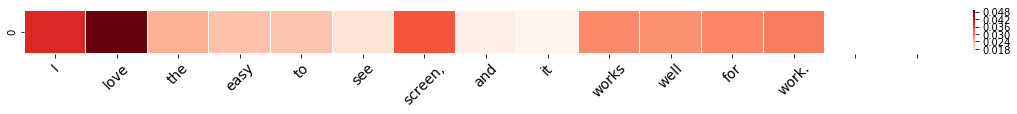

In [14]:
import seaborn as sns

plt.figure(figsize=(20,0.8))
sns.heatmap(weights[6][:13].reshape((1,-1)), cmap='Reds',linewidths=0.01)
plt.xticks(np.arange(len(sentence))+0.5, sentence, fontsize=14, rotation=45)

# plt.xlabel('Sentence', Fontsize=18)
plt.show()


In [15]:
# fname = dataset_files[opt.dataset]['train']

# find = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
# lines = find.readlines()
# find.close

# all_data = []
# for i in range(0, len(lines), 3):
#     text_left, _, text_right = [s.lower().strip() for s in lines[i].partition('$T$')]
#     text_aspect = lines[i+1].lower().strip()
#     polarity = lines[i+2].strip()
#     sentence = text_left + ' ' + text_aspect +' ' + text_right
#     sentence = sentence.split()
    
#     if len(sentence) > 15:     
#         if sentence[6] == text_aspect:
#             print('Label: ', polarity)
#             print('Text: ', text_left + ' *' + text_aspect +'* ' + text_right)
#             print()